In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet as proph
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 98642 (Ridgefield, WA)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Ridgefield = melted[melted.RegionName == 98642]

In [6]:
Ridgefield

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-01-31,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,178735.0
1996-02-29,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,179433.0
1996-03-31,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,179717.0
1996-04-30,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,180419.0
1996-05-31,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,181761.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,518824.0
2021-04-30,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,529447.0
2021-05-31,98642,99937,6314,Ridgefield,WA,Portland-Vancouver-Hillsboro,Clark County,Zip,WA,541648.0


In [7]:
Ridgefield = Ridgefield.resample('MS').mean()
Ridgefield = Ridgefield.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

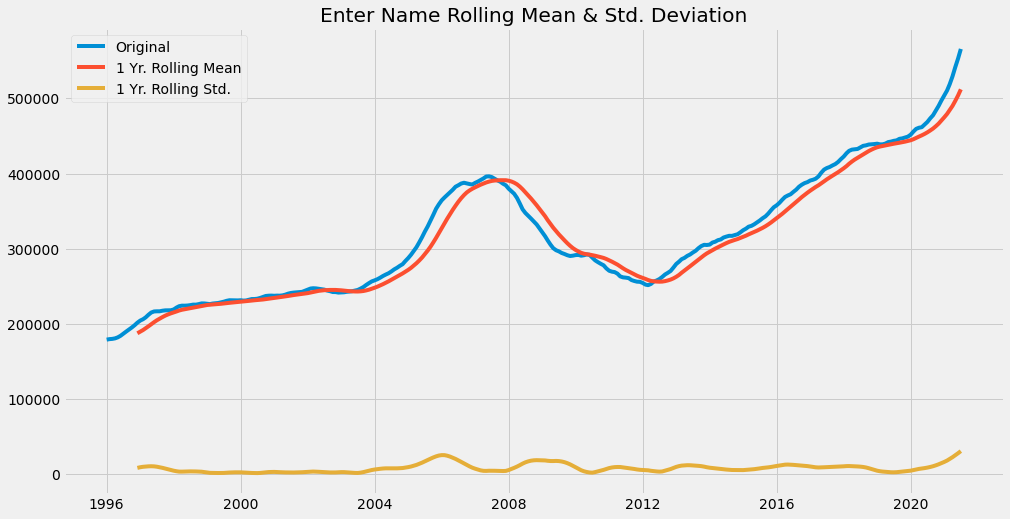

In [8]:
roll_mean_std(Ridgefield)

This plot shows us that there is a positive trend in the data. There is no clear seasonality from this graph, will use a seasonal decompose next to see more information about the data.

### Seasonal Decompose

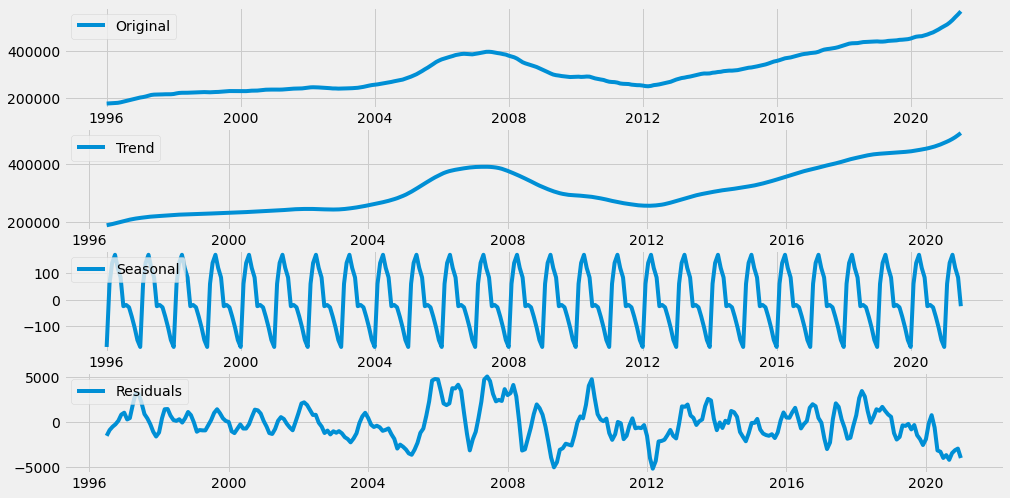

In [9]:
decompose(Ridgefield)

This seasonal decompose shows us more clearly that there is a clear positive linear trend in the data. There is also a seasonal aspect to the data. It would seem that more houses are sold in the summer months and less so in the winter months.

### Differencing and DickeyFuller Test

In [10]:
DickeyFullerTest(Ridgefield)

Test Statistic                   0.872851
p-value                          0.992726
# Lags Used                     16.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64

Test Statistic                  -1.164119
p-value                          0.688837
# Lags Used                     16.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

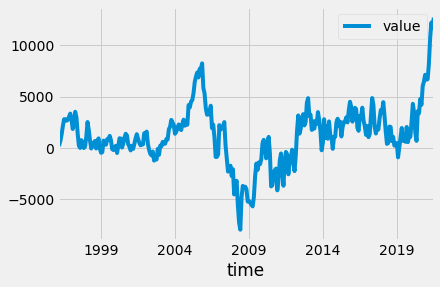

In [11]:
Ridgefield_diff = Ridgefield.diff().dropna()
Ridgefield_diff.plot()
DickeyFullerTest(Ridgefield_diff)

Test Statistic                  -2.958319
p-value                          0.038974
# Lags Used                     16.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64

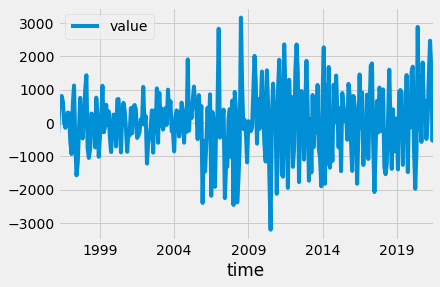

In [12]:
Ridgefield_diff2 = Ridgefield_diff.diff().dropna()
Ridgefield_diff2.plot()
DickeyFullerTest(Ridgefield_diff2)

Second order differencing produced a pvalue <.05, meaning that we can reject the null hypothesis and assume stationarity.

### ACF and PACF

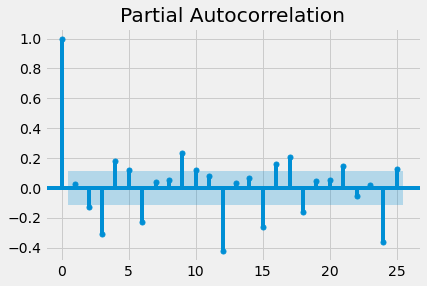

In [13]:
plot_pacf(Ridgefield_diff2);

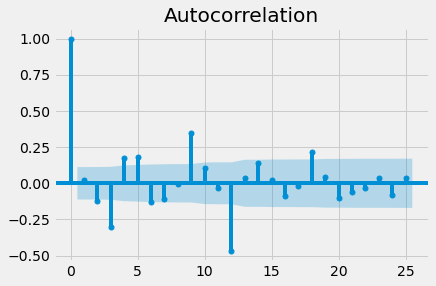

In [14]:
plot_acf(Ridgefield_diff2);

### Train Test Split

In [15]:
cutoff = round(Ridgefield.shape[0]*.8)
train = Ridgefield[:cutoff]
test = Ridgefield[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 2716.51
The Naive Model RMSE for the test data is: 4378.41


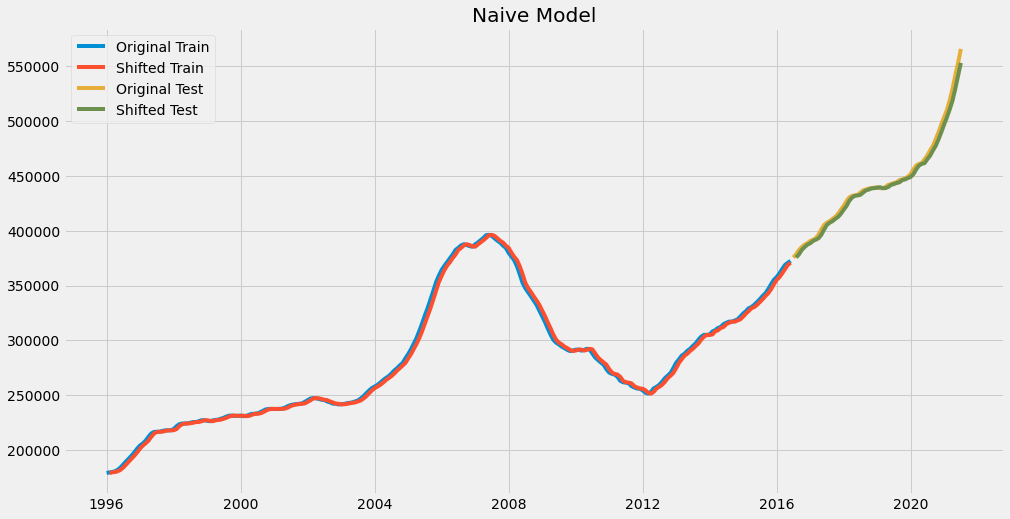

In [16]:
naive_model(train, test)

The RMSE for the Naive Model is 2717 for the train and 4378 on the test data.

## Arima Model

### Random Walk Model

In [17]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

2716.5137802645777

The Random Walk Model RMSE is 2717, the same as the naive model. Let's use Auto ARIMA to select a SARIMAX model.

### Auto ARIMA

In [18]:
auto_Saratoga = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4552.078, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4544.288, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4538.703, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4571.763, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4541.313, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4540.696, Time=0.81 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4540.657, Time=0.70 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4538.708, Time=0.24 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4542.651, Time=2.24 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4549.091, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4582.465, Time=0.96 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=4533.883, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=4536.744, Time=0.17 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=4535.870, Time=0.63 sec
 ARIMA(0,1,2)(0,0,2

In [19]:
sarimax_model = SARIMAX(train, order=(1,1,4), seasonal_order=(1,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

6038.150868811343

Auto ARIMA suggests a SARIMAX that produces an RMSE of 6038 on the training data. 

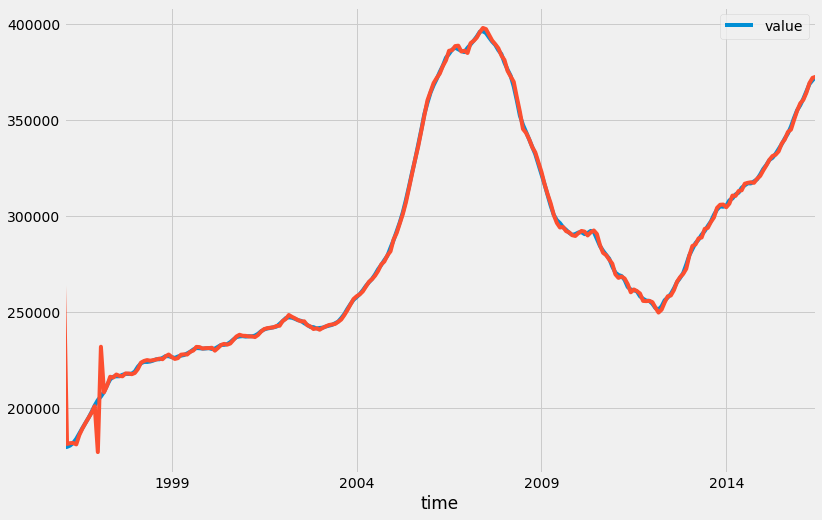

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
train[1:].plot(ax=ax)
yhat_train[1:].plot(ax=ax);

Clearly, the model is having trouble early in the time series.  Let's try a 'brute force' SARIMAX search.

### SARIMAX GridSearch and Model

In [21]:
sarimax_search(train, p=range(1,3), d=range(1,3), q=range(1,3), maxiter=100)

THERE ARE 64 ITERATIONS
Would you like to run the models? (y or n)?n
OK, SARIMAX models will not be run.


In [22]:
sarimax_model2 = SARIMAX(train, order=(1,2,2), seasonal_order=(1,2,2,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model2.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

17390.51724459363

Not a great RMSE at 17391.  Let's move on to Facebook Prophet.

### Facebook Prophet Model

In [23]:
Ridgefield_proph = Ridgefield.reset_index()
Ridgefield_proph = Ridgefield_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 3642.7020147843414
%RMSE:  y    0.011613
dtype: float64


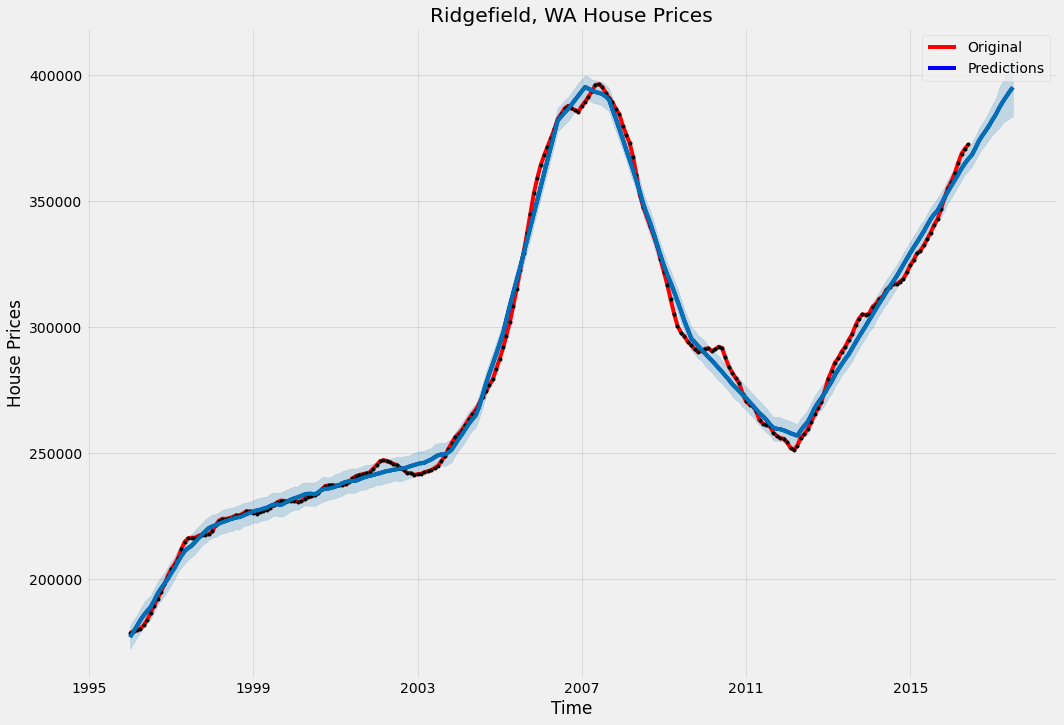

In [24]:
fbprophet_func(Ridgefield_proph, city='Ridgefield, WA')

A much better RMSE than the SARIMAX at 3643.  Let's try a neural network.

### LSTM Model

In [25]:
history = LSTM_func(Ridgefield_proph, City=Ridgefield, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 1s 21ms/step - loss: 0.5884 - val_loss: 50.7380
Epoch 2/100
48/48

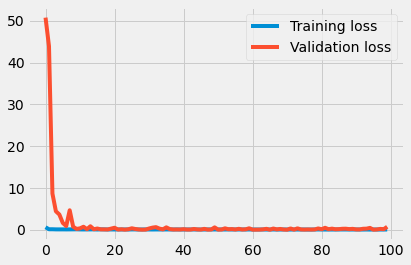

In [26]:
LSTM_val(history)

The LSTM model produces an RMSE above that of the Prophet model.  

## Best Model

We suspect that the Prophet model will be best for making predictions, but let's check the RMSE on the test data first. 

In [27]:
train_proph = train.reset_index()
train_proph = train_proph.rename(columns={'time':'ds', 'value':'y'})

test_proph = test.reset_index()
test_proph = test_proph.rename(columns={'time':'ds', 'value':'y'})

In [28]:
final_model_test = proph(interval_width=.95)
final_model_test.fit(test_proph)
future_dates = final_model_test.make_future_dataframe(0, freq='MS')
forecast_test = final_model_test.predict(future_dates)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
RMSE_test = np.sqrt(mean_squared_error(test_proph.y, forecast_test.yhat))
RMSE_test

2670.226043784824

As suspected, the Prophet model has a low RMSE (2670) on the test data, better than our Naive Model for sure.  Let's use Prophet to make predictions for the next five years.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


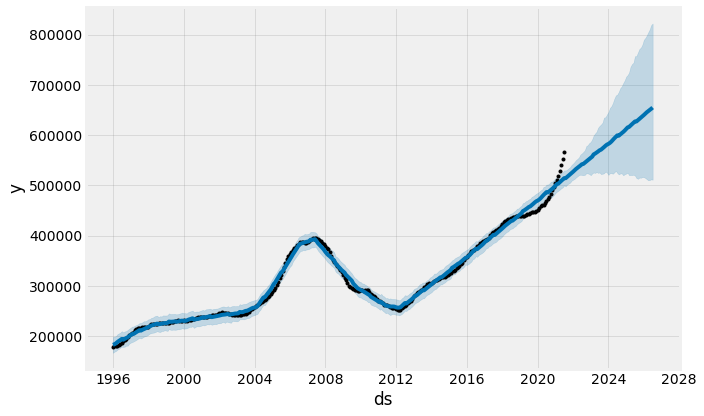

In [30]:
final_model = proph(interval_width=.95)
final_model.fit(Ridgefield_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

In [31]:
forecast_future = forecast.set_index('ds')

In [32]:
forecast_future = forecast_future['2021-08-01':]
forecast_future = forecast_future.reset_index()

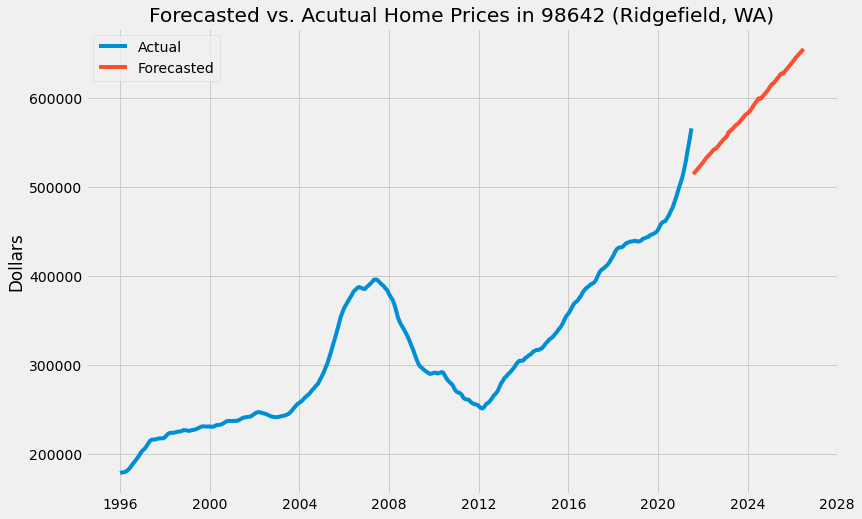

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Ridgefield_proph.ds, Ridgefield_proph.y, label='Actual')
ax.plot(forecast_future.ds, forecast_future.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 98642 (Ridgefield, WA)')
ax.set_ylabel('Dollars')
ax.legend();

In [34]:
current_price = int(Ridgefield_proph[Ridgefield_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $566010
Predicted 2026 price:         $655206
Predicted five year increase: $89196
Predicted five year ROI:      0.15758732177876716


The final Prophet model predicts a five year ROI of 15.8%.